# STL-10 Image Classification

This is a project where I train a deep neural network to classify the STL-10 image dataset. It is an image recognition dataset for developing unsupervised feature learning, deep learning, self-taught learning algorithms inspired by the CIFAR-10 dataset. However, it has fewer labeled images and a massive collection of unlabled images for unsupervised training of the model. The following are the main dataset characteristics:
   
   1. 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
   2. Images are 96x96 pixels, color.
   3. 500 training images (10 pre-defined folds), 800 test images per class.
   4. 100000 unlabeled images for unsupervised learning.
   
Further information can be found here: https://cs.stanford.edu/~acoates/stl10/

The following data import code was written by Martin Tutek, and then tweaked to work with my project. It can be found here: https://github.com/mttk/STL10/blob/master/stl10_input.py

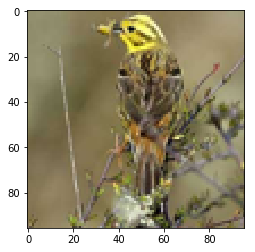

(5000, 96, 96, 3)
(8000, 96, 96, 3)
(5000,)
(8000,)


In [9]:
### From Martin Tutek import code, modified in order to load binary train and test images
from __future__ import print_function

import sys
import os, sys, tarfile, re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import pandas as pd
import scipy.misc
%matplotlib inline
    
if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# path to the binary train file with image data
DATA_PATH = './data/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/train_y.bin'

TEST_PATH = './data/test_x.bin'

TEST_LABEL_PATH = './data/test_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

# test to check if the image is read correctly
with open(DATA_PATH) as f:
    image = read_single_image(f)
    plot_image(image)

# test to check if the whole dataset is read correctly
images = read_all_images(DATA_PATH)
test_images = read_all_images(TEST_PATH)
print(images.shape)
print(test_images.shape)

labels = read_labels(LABEL_PATH)
test_labels = read_labels(TEST_LABEL_PATH)
print(labels.shape)
print(test_labels.shape)

In [20]:
### In order to load the data set into a format that tensorflow can use with its pretrained models, 
### I saved the images into a images folder with each image placed into a subfolder by label (i.e. 10 subfolders)

NUM_LABELS = 10

label_txt = open('data/class_names.txt', 'r').read()
labels_txt = label_txt[:-1].split('\n')

for i in range(NUM_LABELS):
    path = labels_txt[i]
    if not os.path.exists(path):
        os.mkdir(path)

path_test = 'test'
os.mkdir(path_test)
 
# Save all images (train and test) into directory as jpegs    
for i in range(images.shape[0]):
    scipy.misc.toimage(images[i], cmin=0.0, cmax=...).save(str(labels_txt[labels[i]-1])+'/image'+str(i)+'.jpg')
    
for i in range(test_images.shape[0]):
    scipy.misc.toimage(test_images[i], cmin=0.0, cmax=...).save(path_test + '/image'+str(i)+'.jpg')

Now that all the data has been loaded and saved as jpegs, we move to the construction and training of a deepnet for image classification. After doing research on existing deep learning networks, I found that Convolutional Neural Networks (CNNs) are best suited for image classification because they have a fixed-size input and output, and work in a way where each layer of the network "designs" features at a higher level than the previous layer; while the first layer may just identify edges and splotches, the nth layer could have learned the recognition of a door or a face. Recurrent NNs are better suited for sequential data, and more traditional feedforward networks and statistical learning methods don't have the same capacity for unsupervised learning. So the natural choice, based on past success with image classification and recognition tasks, was CNNs.

CNNs have several important steps in their architecture.
    1. Convolution: run a smaller kernel over the entire image with various values to create feature maps
    2. ReLU: a elementwise function that sets all negative values to 0; used to handle for non-linearity of images
    3. Pooling: reduce the dimensionality of the feature maps by keeping important features; invariant and nonoverfitting
    4. Fully-connected Layers: traditional multi-layer perceptron network trained on discovered features
    5. After steps 1-3 identify features, those are fed through a traditional network (step 4), and then we perform backpropogation to train the network and predict classes
    

In selecting which CNN to use, I looked at high-performing pretrained models: LeNet, AlexNet, Inception, ResNet, VGG, SqueezeNet, etc. Many have been pretrained on the ImageNet dataset, making them excellent candidates for retraining to classify images. After doing some research on the various models, my conclusion was that Inception and ResNet were the current cutting edge CNNs, making smaller-size models with higher test accuracy. The biggest innovation leading to Inception's success was the use of 1x1, 3x3, and 5x5 convolutional layers in what is called a bottleneck. This is best explained by Eugenio Culurciello:

    "Let’s say you have 256 features coming in, and 256 coming out, and let’s say the Inception layer only performs 3x3 convolutions. That is 256x256 x 3x3 convolutions that have to be performed (589,000s multiply-accumulate, or MAC operations). That may be more than the computational budget we have, say, to run this layer in 0.5 milli-seconds on a Google Server. Instead of doing this, we decide to reduce the number of features that will have to be convolved, say to 64 or 256/4. In this case, we first perform 256 -> 64 1×1 convolutions, then 64 convolution on all Inception branches, and then we use again a 1x1 convolution from 64 -> 256 features back again. The operations are now: 256×64 × 1×1 = 16,000s; 64×64 × 3×3 = 36,000s; 64×256 × 1×1 = 16,000s. For a total of about 70,000 versus the almost 600,000 we had before. Almost 10x less operations!"
    
This revolutionary idea was used in ResNet and later Inception Models, which made use of additional innovations such as batch-normalization and parallelizing modules. I chose the Inception v3 model for my training because it had performance marginally lower than the Inception v4 and ResNet models, but had significantly lower computational requirements. It was also readily available in Tensorflow's github repository. Eugenio's full analysis can be found here: https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

This is a comparison of the numerous image-classification deepnets over the past couple decades.

<img src="https://cdn-images-1.medium.com/max/800/1*kBpEOy4fzLiFxRLjpxAX6A.png">

This provides a graphical illustration of the construction of the original Inception model.
<img src="https://cdn-images-1.medium.com/max/800/0*CJZdXZULMr_on1Ao.jpg">

The following tensorflow python script loads the Inception v3 model, removes the top, classification layer, and retrains it based on the labelled training images from the STL-10 dataset. This works well because the lower levels of the model have been trained on the ImageNet dataset and create features that are very useful for our similar image classification task. 

The first step is to analyze all the images and creates bottleneck values for all of them. The "bottleneck" layers is the one just below the classification layer: "This penultimate layer has been trained to output a set of values that's good enough for the classifier to use to distinguish between all the classes it's been asked to recognize. That means it has to be a meaningful and compact summary of the images, since it has to contain enough information for the classifier to make a good choice in a very small set of values. The reason our final layer retraining can work on new classes is that it turns out the kind of information needed to distinguish between all the 1,000 classes in ImageNet is often also useful to distinguish between new kinds of objects."

The second step is the training of the final layer. This runs 4000 steps by selecting 10 images at random to run through the final layer and compares them to their labels. It also shows validation accuracy measured against a seperate set of randomly selected images. This serves to prevent overfitting during the training stage of the final layers, by measuring the validation of each training step. This process aims to minimize cross-entropy loss by update weights and biases during training.

Tensorflow description here: https://www.tensorflow.org/versions/r0.12/how_tos/image_retraining/

In [ ]:
### Use tensorflow Inception v3 model and retrain the final fully-connected classification layer for STL dataset
%run retrain.py --image_dir=images --bottleneck_dir=bottlenecks --summaries_dir=training_summaries/long --output_graph=retrained_graph.pb --output_labels=retrained_labels.txt


In [12]:
### Tensorflow tutorial gives python example for using retrained model: https://github.com/eldor4do/TensorFlow-Examples/blob/master/retraining-example.py
### I modified the code in order to predict the STL-10 Test Dataset

modelFullPath = 'retrained_graph.pb'
labelsFullPath = 'retrained_labels.txt'


def create_graph():
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(modelFullPath, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')


def run_inference_on_image(test_path, test_num):
    answers = []

    # Creates graph from saved GraphDef.
    create_graph()

    with tf.Session() as sess:
        
        for i in range(test_num):
            
            imagePath = test_path + 'image' + str(i) + '.jpg'
            
            if not tf.gfile.Exists(imagePath):
                tf.logging.fatal('File does not exist %s', imagePath)
                return answer

            image_data = tf.gfile.FastGFile(imagePath, 'rb').read()

            softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
            predictions = sess.run(softmax_tensor,
                                   {'DecodeJpeg/contents:0': image_data})
            predictions = np.squeeze(predictions)

            top_k = predictions.argsort()[-5:][::-1]  # Getting top 5 predictions
            f = open(labelsFullPath, 'rb')
            lines = f.readlines()
            labels = [str(w).replace("\n", "") for w in lines]
            for node_id in top_k:
                human_string = labels[node_id]
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))

            answers.append(labels[top_k[0]])
            
            print('Record %d complete. %f%s done' % (i, round(i/test_num), '%'))
            
        return answers

In [ ]:
### Predict test set
y_pred = run_inference_on_image('./test/', test_images.shape[0])

In [37]:
### Compare test label predictions against actual predictions and report accuracy
y_pred_clean = np.array([x[2:-3] for x in y_pred])
comp = y_pred_clean == np.array([labels_txt[x-1] for x in test_labels])
print('Accuracy of Inception Model: %f%s' % (comp.sum()*100/comp.size, '%'))

Accuracy of Inception Model: 96.225000%


This model does quite well predicting the test set of the STL-10 dataset, with ~96% accuracy. To improve accuracy in the future, many optional parameters of the training step can be tweaked: the learning rate can be fluctuated to see what the optimal speed of learning is; instead of running 4000 training steps, we could go ahead and run 8000 or 10000; we can also change the training batch size, as well as other hyperparameters, in order to get a more precise model. Finally, if we are able to, we could use the Inception v3 model architecture and train it from scratch using the massive unlabeled dataset provided in STL-10, providing the most accurate possible model for the dataset.